# Title => Triplet Extraction for Knowledge Graph Generation: Rule-Based VS Machine Learning

##**Rule Based Basiline Method Accuracy Check on Test Dataset**

In [ ]:
import re
import pandas as pd
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline


## Dataset Explaination: <br>
A knowledge graph, also known as a semantic network, represents a network of real-world entities—i.e. objects, events, situations, or concepts—and illustrates their relationship. <br> 
This information is usually stored in a graph database and visualised as a graph structure, prompting the term knowledge “graph.” <br> 
A Knowledge graph is extracted as set of triplets i.e. <(Entity-1) (Relation) (Entity-2)> or <(Subject) (Predicate) (Subject)> and then we can visualize them in a graph using any graph generation library of python or databases like Neo4j. 

The most crucial task in any Knowledge Graph creation is triplet extraction, which can be done using machine learning or a rule-based approach. 

We need a dataset to teach our model to extract these triplets;  <br> 
Our dataset generally consists of 4 columns, namely <br> 
1. Sentence # - which contains sentence number <br> 
2. Word – which the words of a sentence, <br> 
3. POS – has Part of Speech of a particular word, <br>
4. Tag – this is the final tag (label) of each sentence word based on BIO tagging scheme. 

## Dataset Creation: <br>
### For Training Dataset: <br>
We use the modified version dataset provided in the paper from which we took the refrence and created a dataset for training which is in category of Abstract 1, and some samples with Abstract 2 as desribed in our "Dataset Description Document". <br>
This dataset is a csv file with 4 columns, namely <br> 
1. Sentence # - which contains sentence number <br>
2. Word – which the words of a sentence, <br>
3. POS – has Part of Speech of a particular word, <br>
4. Tag – this is the final tag (label) of each sentence word based on BIO tagging scheme. <br>
We removed all the long sentences and only selected the sentences with length less than or equal to 20 words. <br>
This dataset consists of around 900 sentences. <br>

### For Validation Dataset: <br>
We have 100 samples curated for this task. We started by handpicking 100 sentences from Wikipedia and thenconverting them to our tagging scheme to pass it to the model.
Ex: Christian is paralyzed an accident. <br>
Christian is the subject, paralyzed is the predicate and accident is the object. <br>


## Reading the dataset

In [ ]:
# import wikipedia sentences
data = pd.read_csv("wiki_sentences_abstract_1.csv")
print(data.shape)
data.head(n=10)

(440, 3)


,Sentence #,Word,Tag
0,Sentence: 1,the,o
1,Sentence: 1,temple,e-1-b
2,Sentence: 1,is,o
3,Sentence: 1,set,r-b
4,Sentence: 1,on,r-i
5,Sentence: 1,fire.,e-2-b
6,Sentence: 2,Actors,e-1-b
7,Sentence: 2,play,r-b
8,Sentence: 2,many,o
9,Sentence: 2,roles.,e-2-b


## Data Preprocessing

In [ ]:
#checking the data types of the columns
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Sentence #  440 non-null    object
 1   Word        440 non-null    object
 2   Tag         440 non-null    object
dtypes: object(3)
memory usage: 10.4+ KB
None


In [ ]:
#checking the null values in the dataframe
print(data.isnull().sum())

Sentence #    0
Word          0
Tag           0
dtype: int64


In [ ]:
#Checking number of duplicate rows in the dataframe
print(f'Number of duplicate rows: {data.duplicated().sum()}')
#displaying the duplicate rows
print(data.loc[data.duplicated()])

Number of duplicate rows: 0
Empty DataFrame
Columns: [Sentence #, Word, Tag]
Index: []


In [ ]:
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords
import numpy as np

from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords
import numpy as np

def dataPreprocess(data):
  nltk.download('stopwords')
  #cleaning up the dataframe column text
  #lowering the text to lower case
  data['Word'] = data['Word'].str.lower()
  print('Word lowered to lower case')
  #removing fullstops, commas, and semi-colons
  data['Word'] = data['Word'].str.replace('[^a-zA-Z0-9]','')
  #stemming the Word
  data['Word'] = data['Word'].apply(lambda x: ' '.join([PorterStemmer().stem(word) for word in x.split()]))
  data = data.loc[~((data['Word'].isin(stopwords.words('english'))) & (data['Tag'] == "o"))]
  print('Word stemmed')
  #removing stop words
  # data['Word'] = data['Word'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))]))
  # print('Stop words removed')
  print(f'Data cleaning process completed')
  #displaying the first 5 rows of the dataframe
  data.head(10)
  #replacing all '' with nan in the dataframe column Word
  data['Word'] = data['Word'].replace('', np.nan)
  print('Replaced all empty strings with nan')
  #totoal number of nan values in the dataframe
  print(f'Total number of nan values: {data["Word"].isnull().sum()}')
  #dropping all the nan values
  data = data.dropna()
  print('Dropped all nan values')
  return data

In [ ]:
data = dataPreprocess(data)
data.head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Word lowered to lower case
Word stemmed
Data cleaning process completed
Replaced all empty strings with nan
Total number of nan values: 10
Dropped all nan values


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Sentence #,Word,Tag
1,Sentence: 1,templ,e-1-b
3,Sentence: 1,set,r-b
4,Sentence: 1,on,r-i
5,Sentence: 1,fire,e-2-b
6,Sentence: 2,actor,e-1-b
7,Sentence: 2,play,r-b
8,Sentence: 2,mani,o
9,Sentence: 2,role,e-2-b
10,Sentence: 3,peopl,e-1-b
12,Sentence: 3,wait,r-b


In [ ]:
#replacing all '' with nan in the dataframe column Word
data['Word'] = data['Word'].replace('', np.nan)
print('Replaced all empty strings with nan')
#totoal number of nan values in the dataframe
print(f'Total number of nan values: {data["Word"].isnull().sum()}')
#dropping all the nan values
data = data.dropna()
print('Dropped all nan values')
#displaying the first 5 rows of the dataframe
data.head(10)

Replaced all empty strings with nan
Total number of nan values: 0
Dropped all nan values


,Sentence #,Word,Tag
1,Sentence: 1,templ,e-1-b
3,Sentence: 1,set,r-b
4,Sentence: 1,on,r-i
5,Sentence: 1,fire,e-2-b
6,Sentence: 2,actor,e-1-b
7,Sentence: 2,play,r-b
8,Sentence: 2,mani,o
9,Sentence: 2,role,e-2-b
10,Sentence: 3,peopl,e-1-b
12,Sentence: 3,wait,r-b


## Exploratory Data Analysis (EDA)

In [ ]:
print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=5) 

Number of sentences:  99
Number of words in the dataset:  267
Tags: ['e-1-b', 'r-i', 'e-2-b', 'r-b', 'o']
Number of Labels:  5
What the dataset looks like:


,Sentence #,Word,Tag
1,Sentence: 1,templ,e-1-b
3,Sentence: 1,set,r-b
4,Sentence: 1,on,r-i
5,Sentence: 1,fire,e-2-b
6,Sentence: 2,actor,e-1-b


In [ ]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 267
Unique tags in corpus: 5


In [ ]:
tags = list(set(data["Tag"].values))
print(tags)
num_tags = len(tags)
print(num_tags)

['e-1-b', 'r-i', 'e-2-b', 'r-b', 'o']
5


In [ ]:
import plotly.express as px

fig = px.histogram(data[~data.Tag.str.contains("O")], x="Tag",color="Tag")
fig.show()

In [ ]:
import tqdm
def sentence_integrate(data):
  agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(), 
                                                  s["Tag"].values.tolist())]
  return data.groupby('Sentence #').apply(agg_func).tolist()
sentences=sentence_integrate(data)

In [ ]:
import plotly.express as px

fig = px.histogram(pd.DataFrame([len(s) for s in sentences],columns=['length']),x="length",marginal='box')
fig.show()

## Extracting Triplets from the dataset using Rule-Based Approach on Training Dataset to test the performance of the rule-based approach

In [ ]:
import tqdm
def sentence_integrate(data):
  agg_func = lambda s: [w for w in s["Word"].values.tolist()]
  return data.groupby('Sentence #').apply(agg_func).tolist()

curatedData = sentence_integrate(data)

In [ ]:
print(curatedData[:5])
#create list of string from list of list of words and add space after every element except the last
def list_to_string(list_of_list_of_words):
    list_of_string = []
    for list_of_words in list_of_list_of_words:
        string = ""
        for word in list_of_words:
            string += word + " "
        list_of_string.append(string)
    return list_of_string
myWords = list_to_string(curatedData)


[['templ', 'set', 'on', 'fire'], ['player', 'triumph', 'jumaji'], ['71', 'receiv', 'applaud'], ['wife', 'jump', 'conclus'], ['seri', 'air', 'juli']]


In [ ]:
print(myWords[:5])

['templ set on fire ', 'player triumph jumaji ', '71 receiv applaud ', 'wife jump conclus ', 'seri air juli ']


In [ ]:
df_data = pd.DataFrame(myWords, columns=['sentence'])
df_data['sentence'].sample(5)

68      youth fill with ambit 
36           sun rise in east 
54           everyon is equal 
69        film wa direct by y 
43    sandberg wa kill by him 
Name: sentence, dtype: object

In [ ]:
#total number of sentences
print(len(df_data))

99


### Entities Extraction

In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

### Named Entity Recognition Rules
Chunk 1

Defined a few empty variables in this chunk. prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word in the sentence and that previous word itself, respectively. prefix and modifier will hold the text that is associated with the subject or the object.

Chunk 2

Next, we will loop through the tokens in the sentence. We will first check if the token is a punctuation mark or not. If yes, then we will ignore it and move on to the next token. If the token is a part of a compound word (dependency tag = “compound”), we will keep it in the prefix variable. A compound word is a combination of multiple words linked to form a word with a new meaning (example – “Football Stadium”, “animal lover”).

As and when we come across a subject or an object in the sentence, we will add this prefix to it. We will do the same thing with the modifier words, such as “nice shirt”, “big house”, etc.

Chunk 3

Here, if the token is the subject, then it will be captured as the first entity in the ent1 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.

Chunk 4

Here, if the token is the object, then it will be captured as the second entity in the ent2 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset.

Chunk 5

Once we have captured the subject and the object in the sentence, we will update the previous token and its dependency tag.

In [ ]:
entity_pairs = []

for i in df_data['sentence']:
  entity_pairs.append(get_entities(i))

In [ ]:
entity_pairs[10:20]

[['holden', ''],
 ['actor', 'mani role'],
 ['soni', 'deal'],
 ['', 'indian  kuwait'],
 ['', ''],
 ['', ''],
 ['', 'plan'],
 ['fire', 'wire'],
 ['franc', ''],
 ['', 'websit']]

### Relations Extraction

Our hypothesis is that the predicate is actually the main verb in a sentence.

For example, in the sentence – “Sixty Hollywood musicals were released in 1929”, the verb is “released in” and this is what we are going to use as the predicate for the triple generated from this sentence.

The function below is capable of capturing such predicates from the sentences. Here, I have used spaCy’s rule-based matching:

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 
            
  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
relations = [get_relation(i) for i in df_data['sentence']]

In [ ]:
pd.Series(relations).value_counts()[:50]

goe to          3
play            3
ha              2
wear            2
made            2
is              2
write           2
receiv          1
rao             1
debut in        1
arriv by        1
slaveri         1
direct by       1
fill with       1
set on          1
enemi           1
express         1
lee             1
forget          1
forgiv          1
mother          1
merg with       1
speak           1
live in         1
is equal        1
love            1
wound in        1
gain            1
resign in       1
sam             1
want            1
realli proud    1
consum          1
written by      1
coupl           1
author          1
referenc in     1
kennedi         1
wrist           1
laundri         1
is spheric      1
mathemat        1
blake           1
announc         1
releas for      1
simi            1
breach          1
is bisexu       1
revolut         1
lose            1
dtype: int64

### Converting to Triplets

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

#creating a list of Sentence ID and Subject and Object
sentence_id = ["Sentence: "+str(i) for i in range(len(source))]

kg_df = pd.DataFrame({'sentence_id':sentence_id, 'Source':source, 'Target':target, 'Relation':relations})

In [ ]:
print(kg_df.shape)
kg_df.head()

(99, 4)


,sentence_id,Source,Target,Relation
0,Sentence: 0,templ,fire,set on
1,Sentence: 1,,,jumaji
2,Sentence: 2,,,applaud
3,Sentence: 3,wife,,conclus
4,Sentence: 4,,,juli


In [ ]:
def getSrTrRlDataFrame(data):
  #for each sentence in the dataset, create 3 lists source, relation, target
  #source is the word with tag "e-1-b" or "e-1-i", target is the word with tag "e-2-b" or "e-2-i" and
  #relation is the tag "r-b" or "r-i"
  source = []
  target = []
  relation = []

  #for each unique sentence in the dataset
  for i in data.groupby(['Sentence #']):
      #get the sentence number
      sent_num = i[0]
      #get the sentence
      sent = i[1]
      #get the number of rows in the sentence
      n_rows = len(sent)
      #for each row in the sentence
      temp_source = []
      temp_target = []
      temp_relation = []
      for j in range(n_rows):
          #get the word
          word = sent["Word"].values[j]
          #get the tag
          tag = sent["Tag"].values[j]
          #if the tag is "e-1-b" or "e-1-i"
          if tag == "e-1-b" or tag == "e-1-i":
              #add the word to the source list
              temp_source.append(word)
          #if the tag is "e-2-b" or "e-2-i"
          elif tag == "e-2-b" or tag == "e-2-i":
              #add the word to the target list
              temp_target.append(word)
          #if the tag is "r-b" or "r-i"
          elif tag == "r-b" or tag == "r-i":
              #add the word to the relation list
              temp_relation.append(word)
      #add the source, target and relation lists to the source, target and relation lists
      #converting list to string
      source.append(" ".join(temp_source))
      target.append(" ".join(temp_target))
      relation.append(" ".join(temp_relation))
      
      

  #print the first 10 source words
  print("Source words:")
  print(source[:10])
  #print the first 10 target words
  print("Target words:")
  print(target[:10])
  #print the first 10 relation words
  print("Relation words:")
  print(relation[:10])

  #creating dataframe for source, target and relation with 3 columns
  df = pd.DataFrame(columns=['Source', 'Target', 'Relation'], data=list(zip(source, target, relation)))
  #print the first 10 rows of the dataframe
  print(df.head(n=5))
  return df

In [ ]:
df = getSrTrRlDataFrame(data)

Source words:
['templ', 'player', '71', 'wife', 'seri', 'brother', 'final sister', 'jessi', 'jessica', 'walter']
Target words:
['fire', 'jumaji', 'applaud', 'conclus', 'juli', 'write', 'peac', 'hous', 'owner', 'scar']
Relation words:
['set on', 'triumph', 'receiv', 'jump', 'air', 'passion about', 'made', 'bought', 'is', 'deserv']
   Source   Target Relation
0   templ     fire   set on
1  player   jumaji  triumph
2      71  applaud   receiv
3    wife  conclus     jump
4    seri     juli      air


In [ ]:
#function to compare 2 strings and return the number of matching words
def compare_strings(str1, str2):
    #split the strings into words
    str1 = str1.split()
    str2 = str2.split()
    #initialize the count
    count = 0
    #for each word in the first string
    for word in str1:
        #if the word is in the second string
        if word in str2:
            #increment the count
            count += 1
    #return the count
    return count

def compareDF(df1, df2):

  source_matches = 0
  target_matches = 0
  relation_matches = 0

  #iterate over 2 dataframes df and kg_df and compare the source columns of both dataframes
  for i in range(len(df1)):
      #get the source column of the current row
      source_i = df1.iloc[i]['Source']
      #get the source column of the current row of kg_df
      source_kg = df2.iloc[i]['Source']
      #cal the compare_strings function and store the result in the source_match list
      temp_s = compare_strings(source_i, source_kg)
      if temp_s > 0:
        source_matches+=1

      #get the target column of the current row
      target_i = df1.iloc[i]['Target']
      #get the target column of the current row of df2
      target_kg = df2.iloc[i]['Target']
      #cal the compare_strings function and store the result in the target_match list
      temp_t = compare_strings(target_i, target_kg)
      if temp_t > 0:
        target_matches+=1

      #get the relation column of the current row
      relation_i = df1.iloc[i]['Relation']
      #get the relation column of the current row of df2
      relation_kg = df2.iloc[i]['Relation']
      #cal the compare_strings function and store the result in the relation_match list
      temp_r = compare_strings(relation_i, relation_kg)
      if temp_r > 0:
        relation_matches+=1

  #calulate percentage of matches for source, target and relation with df counts
  source_match_percent = source_matches / len(df1)
  target_match_percent = target_matches / len(df1)
  relation_match_percent = relation_matches / len(df1)

  #print the percentage of matches for source, target and relation
  print("Percentage of matches for source: ", source_match_percent)
  print("Percentage of matches for target: ", target_match_percent)
  print("Percentage of matches for relation: ", relation_match_percent)


## Calulating the Accuracy of the Rule-Based Approach with at least match:

In [ ]:
compareDF(df, kg_df)

Percentage of matches for source:  0.5454545454545454
Percentage of matches for target:  0.5656565656565656
Percentage of matches for relation:  0.696969696969697


In [ ]:
#replacing all '' with nan in the dataframe column Word
kg_df['Source'] = kg_df['Source'].replace('', np.nan)
kg_df['Target'] = kg_df['Target'].replace('', np.nan)
kg_df['Relation'] = kg_df['Relation'].replace('', np.nan)
print('Replaced all empty strings with nan')
#totoal number of nan values in the kg_dfframe
print(f'Total number of nan values: {kg_df["Source"].isnull().sum()}')
print(f'Total number of nan values: {kg_df["Target"].isnull().sum()}')
print(f'Total number of nan values: {kg_df["Relation"].isnull().sum()}')
#dropping all the nan values
kg_df = kg_df.dropna()
print('Dropped all nan values')
#displaying the first 5 rows of the kg_dfframe
kg_df.head(10)

Replaced all empty strings with nan
Total number of nan values: 40
Total number of nan values: 41
Total number of nan values: 0
Dropped all nan values


,sentence_id,Source,Target,Relation
0,Sentence: 0,templ,fire,set on
6,Sentence: 6,final sister,peac,made
11,Sentence: 11,actor,mani role,play
12,Sentence: 12,soni,deal,made
17,Sentence: 17,fire,wire,burn
20,Sentence: 20,noth,thi,stop
21,Sentence: 21,ndtv,it,rate
23,Sentence: 23,canada,champhionship,won
25,Sentence: 25,it,sync,wa out
26,Sentence: 26,she,power,ha


In [ ]:
kg_df.shape

(42, 4)

## Calulating the Accuracy of the Rule-Based Approach with full match

In [ ]:
#calculate percentage of matches over data dataframe size
percentage_of_matches = (kg_df.shape[0]/len(df))*100

In [ ]:
print("Accuracy is: " + str(percentage_of_matches))

Accuracy is: 42.42424242424242


## Calculation Model Prediction

In [ ]:
abs_1_org = pd.read_csv('RNN Model_6_Pred_Abs_2.csv')
preLen = len(abs_1_org)
print(preLen)
abs_1_org.head()

576


,Unnamed: 0,Sentence #,Word,Tag,Pred
0,0,0,christian,e-1-b,r-i
1,1,0,paralyz,r-b,e-2-i
2,2,0,by,r-i,e-1-b
3,3,0,accid,e-2-b,o
4,4,1,mauro,e-1-b,e-1-b


In [ ]:
tempDF = pd.DataFrame()
def que(x):
    if x['Tag'] == x['Pred']:
        return 1
    return np.nan
tempDF['que'] = abs_1_org.apply(que, axis=1)
tempDF = tempDF.dropna()
len_after_drop = len(tempDF)
print(len_after_drop)
tempDF.head()

82


,que
4,1.0
7,1.0
8,1.0
11,1.0
22,1.0


In [ ]:
#Tag Wise Accuracy
print((len_after_drop/preLen)*100)

14.23611111111111


In [ ]:
try:
  abs_1_org.drop(['Unnamed: 0', 'Pred'], axis=1, inplace=True)
except:
  abs_1_org.drop(['Pred'], axis=1, inplace=True)
print(abs_1_org.head())
print(abs_1_org.shape)

   Sentence #       Word    Tag
0           0  christian  e-1-b
1           0    paralyz    r-b
2           0         by    r-i
3           0      accid  e-2-b
4           1      mauro  e-1-b
(576, 3)


In [ ]:
abs_1_pred = pd.read_csv('RNN Model_6_Pred_Abs_2.csv')
try:
  abs_1_pred.drop(['Unnamed: 0', 'Tag'], axis=1, inplace=True)
except:
  abs_1_pred.drop(['Tag'], axis=1, inplace=True)

abs_1_pred.rename(columns={'Pred': 'Tag'}, inplace=True)
print(abs_1_pred.head())
print(abs_1_pred.shape)

   Sentence #       Word    Tag
0           0  christian    r-i
1           0    paralyz  e-2-i
2           0         by  e-1-b
3           0      accid      o
4           1      mauro  e-1-b
(576, 3)


In [ ]:
abs_1_org_kg = getSrTrRlDataFrame(abs_1_org)
abs_1_pred_kg = getSrTrRlDataFrame(abs_1_pred)

Source words:
['christian', 'mauro fior', 'sifi categori', 'holiday horror', 'hemsworth', 'side effect', 'mani horror film', 'film', 'soundtrack', 'album']
Target words:
['accid', 'cinematograph', 'fantasi genr', 'horror event', 'fame', 'sleepless', 'great social controversi', 'octob', 'june 7', 'august 2']
Relation words:
['paralyz by', 'serv as', 'fuse', 'depict', 'gain', 'is', 'creat', 'complet by', 'releas digit', 'releas digit']
           Source         Target    Relation
0       christian          accid  paralyz by
1      mauro fior  cinematograph     serv as
2   sifi categori   fantasi genr        fuse
3  holiday horror   horror event      depict
4       hemsworth           fame        gain
Source words:
['by', 'mauro serv', 'categori genr', '', 'hemsworth', 'one side is', 'mani film great controversi', '', '', '']
Target words:
['paralyz', 'cinematograph', 'fuse', 'holiday horror event', 'gain fame hi appear thor', '', '', 'complet by', 'releas digit', 'releas digit']
Relation

In [ ]:
print(abs_1_org_kg.shape)
print(abs_1_pred_kg.shape)

(104, 3)
(104, 3)


In [ ]:
compareDF(abs_1_org_kg, abs_1_pred_kg)

Percentage of matches for source:  0.38461538461538464
Percentage of matches for target:  0.41346153846153844
Percentage of matches for relation:  0.4326923076923077


In [ ]:
#replacing all '' with nan in the dataframe column Word
abs_1_pred_kg['Source'] = abs_1_pred_kg['Source'].replace('', np.nan)
abs_1_pred_kg['Target'] = abs_1_pred_kg['Target'].replace('', np.nan)
abs_1_pred_kg['Relation'] = abs_1_pred_kg['Relation'].replace('', np.nan)
print('Replaced all empty strings with nan')
#totoal number of nan values in the abs_1_pred_kgframe
print(f'Total number of nan values: {abs_1_pred_kg["Source"].isnull().sum()}')
print(f'Total number of nan values: {abs_1_pred_kg["Target"].isnull().sum()}')
print(f'Total number of nan values: {abs_1_pred_kg["Relation"].isnull().sum()}')
#dropping all the nan values
abs_1_pred_kg = abs_1_pred_kg.dropna()
print('Dropped all nan values')
#displaying the first 5 rows of the abs_1_pred_kgframe
abs_1_pred_kg.head(10)

Replaced all empty strings with nan
Total number of nan values: 27
Total number of nan values: 8
Total number of nan values: 11
Dropped all nan values


,Source,Target,Relation
0,by,paralyz,christian
1,mauro serv,cinematograph,fior as
2,categori genr,fuse,sifi fantasi
10,distribut by,film pictur,walt disney
11,approach,employe,vivienn graham former
12,play,joe older,morton as
14,treatment,research,discov
17,stuntman,replac,actor
18,poster,main releas,onlin
19,wa,home on june,8th 2018


In [ ]:
abs_1_pred_kg.shape

(60, 3)

In [ ]:
#calculate percentage of matches over data dataframe size
percentage_of_matches = (abs_1_pred_kg.shape[0]/len(abs_1_org_kg))*100

In [ ]:
print("Accuracy is: " + str(percentage_of_matches))

Accuracy is: 57.692307692307686


## Calculating Classification Report

In [ ]:
X_test_1_df = pd.read_csv('Model_7_Pred_Abs_2.csv')

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(X_test_1_df["Tag"], X_test_1_df["Pred"], zero_division=1)
print(report)

              precision    recall  f1-score   support

       e-1-b       0.86      0.64      0.73       103
       e-1-i       0.20      0.45      0.28        73
       e-2-b       0.40      0.20      0.26       106
       e-2-i       0.50      0.40      0.44        78
           o       0.10      0.42      0.17        45
         r-b       0.24      0.08      0.13       106
         r-i       1.00      0.02      0.03        65

    accuracy                           0.31       576
   macro avg       0.47      0.32      0.29       576
weighted avg       0.49      0.31      0.31       576



In [ ]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(X_test_1_df["Tag"], X_test_1_df["Pred"])
print(cf_matrix)

[[66  2  0  0 35  0  0]
 [ 6 33  2  1 28  3  0]
 [ 0 29 21 17 26 13  0]
 [ 0 11 14 31 18  4  0]
 [ 1 17  3  3 19  2  0]
 [ 4 48  5  3 37  9  0]
 [ 0 23  8  7 20  6  1]]


In [ ]:
tags = np.unique(X_test_1_df["Tag"]).tolist()
print(tags)

['e-1-b', 'e-1-i', 'e-2-b', 'e-2-i', 'o', 'r-b', 'r-i']


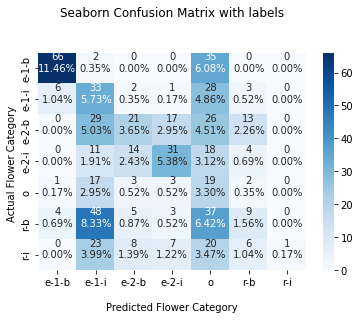

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(cf_matrix.shape[0],cf_matrix.shape[0])

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Flower Category')
ax.set_ylabel('Actual Flower Category ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(tags)
ax.yaxis.set_ticklabels(tags)
## Display the visualization of the Confusion Matrix.
plt.show()

## Plotting ROC and AUC

In [ ]:
df_test_1 = pd.read_csv('Model_5_Pred_Abs_1.csv')
df_test_2 = pd.read_csv('Model_5_Pred_Abs_2.csv')
df_test_3 = pd.read_csv('Model_6_Pred_Abs_1.csv')
df_test_4 = pd.read_csv('Model_6_Pred_Abs_2.csv')
df_test_5 = pd.read_csv('Model_7_Pred_Abs_1.csv')
df_test_6 = pd.read_csv('Model_7_Pred_Abs_2.csv')

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px


y_test = df_test_6["Tag"]
y_score = df_test_6["Pred"]

# One hot encode the labels in order to plot them
y_onehot = pd.get_dummies(y_test, columns=np.unique(y_test).tolist())
y_score_onehot = pd.get_dummies(y_score, columns=np.unique(y_score).tolist())
# Create an empty figure, and iteratively add new lines
# every time we compute a new class
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for i in range(y_score_onehot.shape[1]):
    try:
      y_true = y_onehot.iloc[:, i]
      y_score = y_score_onehot.iloc[:, i]

      fpr, tpr, _ = roc_curve(y_true, y_score)
      auc_score = roc_auc_score(y_true, y_score)

      name = f"{y_onehot.columns[i]} (AUC={auc_score:.2f})"
      fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))
    except:
      print()
fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=700, height=500
)
fig.show()


## Refrences:
1.	https://www.sciencedirect.com/topics/computer-science/recurrent-neural-network#:~:text=A%20recurrent%20neural%20network%20(RNN)%20is%20a%20special%20kind%20of,next%20word%20of%20a%20sentence.
2.	Knowledge Graph & NLP Tutorial-(BERT,spaCy,NLTK) | Kaggle
3.	named-entity-recognition-template/ner.ipynb at master · floydhub/named-entity-recognition-template · GitHub
4.	GitHub - BeiqiZh/Named-Entity-Recognition: Named Entity Recognition (NER) using LSTMs with Keras
5.	tensorflow - why set return_sequences=True and stateful=True for tf.keras.layers.LSTM? - Stack Overflow
6.	Text classification with an RNN  |  TensorFlow
7.	https://www.coursera.org/lecture/machine-learning/diagnosing-bias-vs-variance-yCAup
8.	https://github.com/gabrielStanovsky/supervised-oie
9.	What is a Knowledge Graph? | IBM 
10.	https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
11.	https://nlp.stanford.edu/projects/glove/
